In [1]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from keras.layers import Activation

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   activation='mish' if conv['activ'] == 2 else None,
                   use_bias=True)(x)
                  
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov3_tiny_model():
        
    input_image = Input(shape=(416, 416, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 16, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 0}])
    
    # Layer  1
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_1')(x)
    
    # Layer  2
    x = _conv_block(x, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 2}])
  
    # Layer  3
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_3')(x)
    
    # Layer  4
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 4}])   

    # Layer  5
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_5')(x)
    
    # Layer  6
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 6}])   
    
    # Layer  7
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_7')(x)
    
    # Layer  8
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 8}])   
    layer_8 = x
    
    # Layer  9
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_9')(x)
    
    # Layer  10
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 10}])
    layer_10 = x
    
    # Layer  11
    x = MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'max_11')(x)
    
    # Layer  12
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 12}])

    
    ###########
    
    # Layer  13
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 13}]) 
    layer_13 = x
        
    # Layer  14
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 14}])     
    
    # Layer  15
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 15}])    
    
    # Layer  16
    yolo_16 = x
    
    
    # Layer  17
    x = layer_13

    # Layer  18
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 18}])
   
    # Layer  19
    x = UpSampling2D(size=(2, 2), name = 'upsamp_19')(x)

    # Layer  20
    x = concatenate([layer_8, x],  name='concatenate_20')
    
    # Layer  21
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 21}])     
    
    # Layer  22
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 22}])    
    
    # Layer  23
    yolo_23 = x   
                                      
    model = Model(input_image, [yolo_16, yolo_23], name = 'Yolo_v3_tiny')    
    return model

Using TensorFlow backend.


TensorFlow version: 2.1.0
Eager execution: True
Keras version: 2.2.4-tf


In [4]:
# Define the model
model = make_yolov3_tiny_model()

In [5]:
model.summary()

Model: "Yolo_v3_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 416, 416, 16) 448         input_0[0][0]                    
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 16) 0           convn_0[0][0]                    
__________________________________________________________________________________________________
max_1 (MaxPooling2D)            (None, 208, 208, 16) 0           leaky_0[0][0]                    
_______________________________________________________________________________________

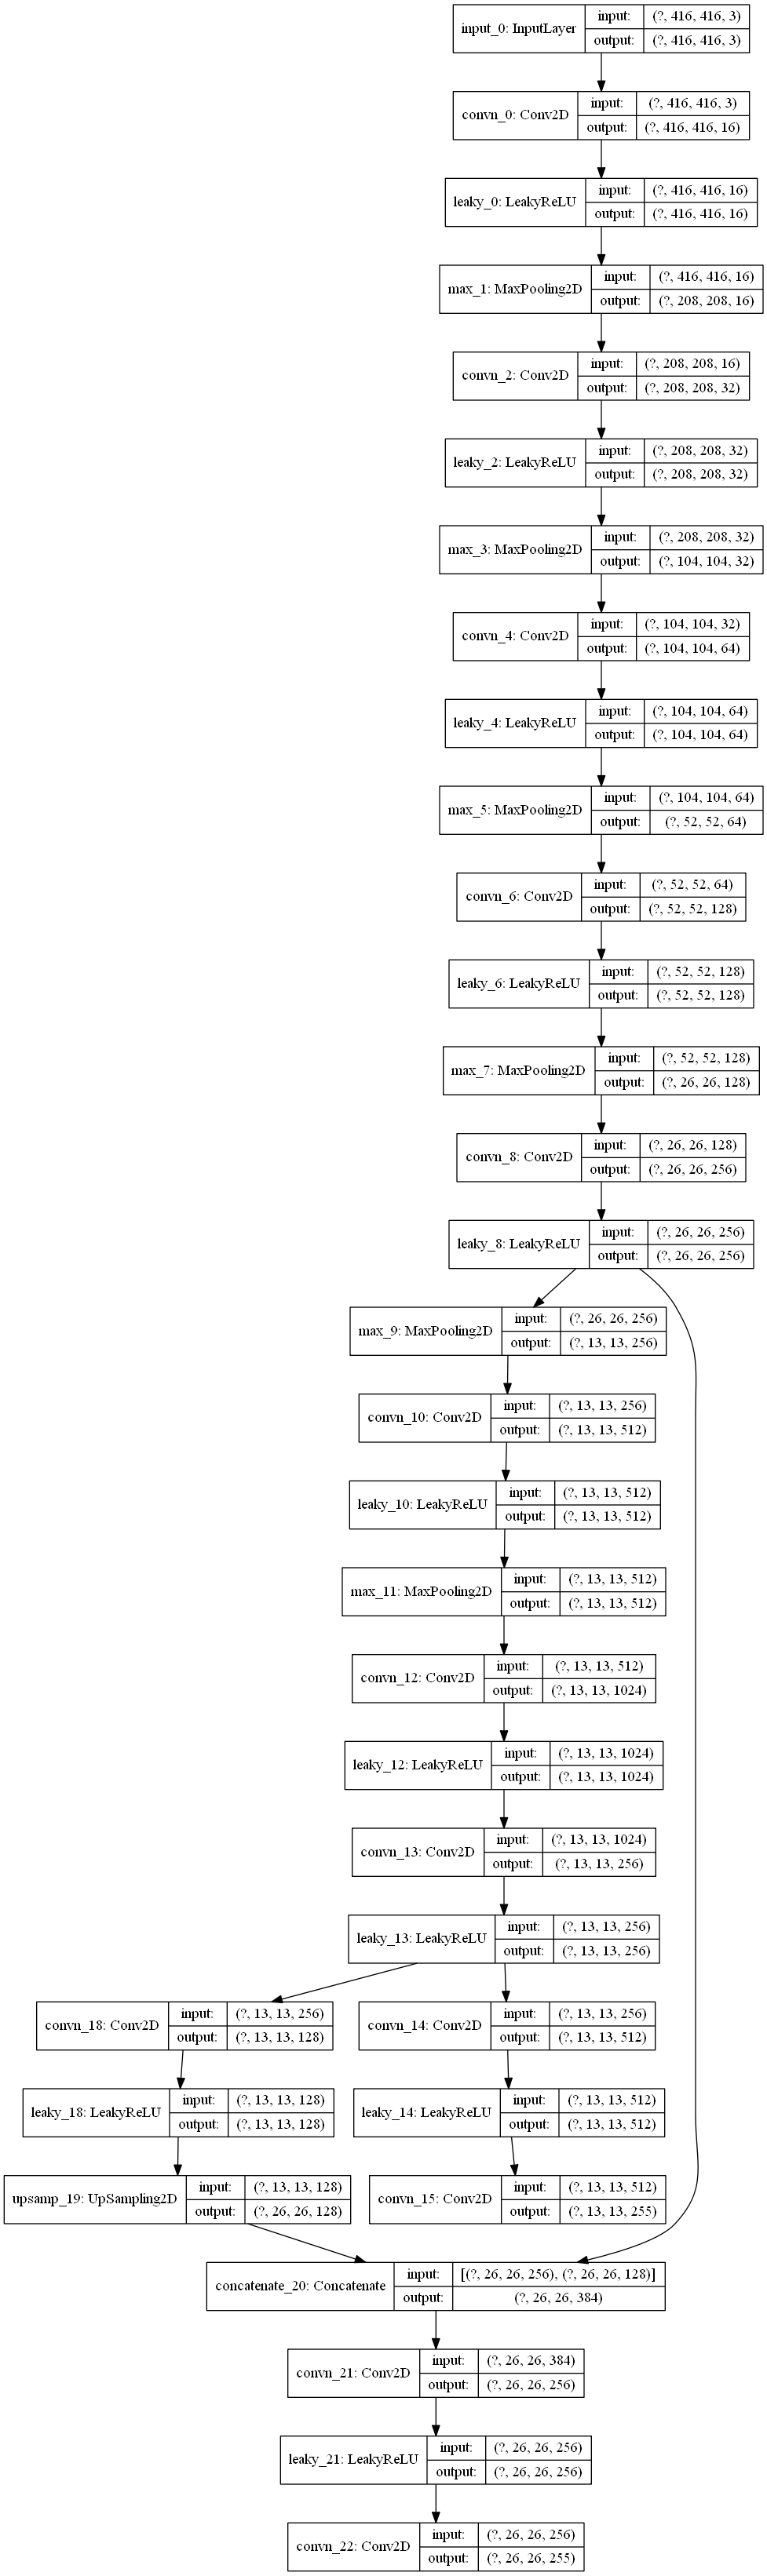

In [6]:
tf.keras.utils.plot_model( model, show_shapes=True)

In [12]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(23):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [15, 22]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0


In [13]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov3-tiny.weights')
weight_reader.load_weights(model)


reading 64 bytes
loading weights of convolution #0- nb parameters: 448
no convolution #1
loading weights of convolution #2- nb parameters: 4640
no convolution #3
loading weights of convolution #4- nb parameters: 18496
no convolution #5
loading weights of convolution #6- nb parameters: 73856
no convolution #7
loading weights of convolution #8- nb parameters: 295168
no convolution #9
loading weights of convolution #10- nb parameters: 1180160
no convolution #11
loading weights of convolution #12- nb parameters: 4719616
loading weights of convolution #13- nb parameters: 262400
loading weights of convolution #14- nb parameters: 1180160
loading weights of convolution #15- nb parameters: 130815
Special processing for layer 15
no convolution #16
no convolution #17
loading weights of convolution #18- nb parameters: 32896
no convolution #19
no convolution #20
loading weights of convolution #21- nb parameters: 884992
loading weights of convolution #22- nb parameters: 65535
Special processing for 

In [15]:
# save the model to file
! rm models\yolo\yolov3-tiny.h5

model.save('models/yolo/yolov3-tiny.h5')
! dir models\yolo\*.h5

 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est CCDC-AB26

 R‚pertoire de C:\Users\edh\yolo4\Yolov-4\models\yolo

09/06/2020  12:28        35ÿ474ÿ940 yolov3-tiny.h5
09/06/2020  12:26        35ÿ474ÿ940 yolov4.h5
               2 fichier(s)       70ÿ949ÿ880 octets
               0 R‚p(s)  246ÿ451ÿ040ÿ256 octets libres


In [16]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov3-tiny.h5")

C:\Users\edh\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [19]:
# Load the labels
labels = read_labels("models/yolo/coco_classes.txt")
print(labels)
print("nb labels: ",len(labels))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
nb labels:  80


In [34]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [35]:
# Pre-process the image
input_w, input_h = 416, 416
photo_filename = 'images/6dogs.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  300 168
input image (1, 416, 416, 3)


In [36]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])


output [(1, 13, 13, 255), (1, 26, 26, 255)]


In [37]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, nb_box, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [38]:
# Compute the Yolo layers
obj_thresh = 0.25
anchors = [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
scales_x_y = [1.0, 1.0]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, 3, scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  13 13
nb class:  80
objectness:  0.7070602
objectness:  0.5733239
objectness:  0.34073707
objectness:  0.39419454
objectness:  0.4524389
objectness:  0.2625877
grid_h,grid_w:  26 26
nb class:  80
nb boxes detected;  6


In [39]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [40]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [41]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [42]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.5)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  6


In [43]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [44]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.25
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  4


In [45]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

dog 69.49385404586792 13 97 53 121
dog 55.952149629592896 95 164 52 125
dog 35.32145619392395 159 233 51 131
dog 39.82221484184265 203 281 56 134


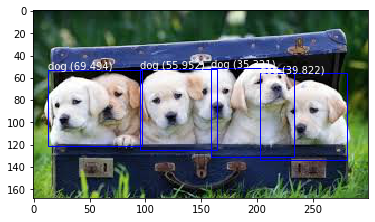

In [46]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)